[Reference](https://medium.com/@jonas.schumacher/neural-network-layer-masking-in-pytorch-151dd834476e)

In [1]:
from dataclasses import dataclass
from typing import Dict, List, Tuple

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error

In [2]:
class MaskedLayer(torch.nn.Linear):
    def __init__(
        self,
        in_features: int,    # e.g., 6
        out_features: int,   # e.g., 2
        mask: torch.Tensor,  # e.g., shape(2,6)
    ):
        super().__init__(
            in_features=in_features,
            out_features=out_features,
            bias=False,      # no need to use a bias in our case
        )
        self.mask = mask

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.nn.functional.linear(x, self.weight * self.mask, self.bias)
        return x

In [3]:
class CustomModel(torch.nn.Module):
    def __init__(
            self,
            in_features: int,    # e.g., 6
            out_features: int,   # e.g., 2
            mask: torch.Tensor,  # e.g., shape(2,6)
        ) -> None:
            super(CustomModel, self).__init__()

            self.masked_layer = MaskedLayer(
                in_features=in_features,
                out_features=out_features,
                mask=mask,
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.masked_layer(x)
        return x

In [4]:
LEARNING_RATE = 1.0
NUM_TRAIN_EPOCHS = 5

torch.manual_seed(42)


@dataclass
class TrainingResults:
    loss_timeseries: List[Dict[int, float]]
    trained_weights: np.ndarray


def train_model(
        features: np.ndarray,
        targets: np.ndarray,
        mask: np.ndarray,
) -> TrainingResults:
    torch_features = torch.tensor(features, dtype=torch.float32)
    torch_targets = torch.tensor(targets, dtype=torch.float32)
    torch_mask = torch.tensor(mask, dtype=torch.float32)

    model = CustomModel(
        in_features=torch_features.shape[1],
        out_features=torch_targets.shape[1],
        mask=torch_mask,
    )

    print(
        f"Masked weights before training: {model.masked_layer.weight.detach()[torch_mask == 0.0]}"
    )
    print(f"Bias before training: {model.masked_layer.bias}")

    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.LBFGS(
        params=model.parameters(),
        lr=LEARNING_RATE,
    )

    def train_epoch() -> None:
        model.train()

        def closure() -> torch.float:
            optimizer.zero_grad()
            y_pred = model(torch_features)
            loss = loss_function(y_pred, torch_targets)
            loss.backward()
            return loss

        optimizer.step(closure)

    def evaluate_epoch() -> Dict[int, float]:
        model.eval()
        with torch.no_grad():
            y_pred = model(torch_features)
            metrics = {
                t: mean_absolute_error(
                    y_pred=y_pred.numpy()[:, t],
                    y_true=torch_targets.numpy()[:, t],
                )
                for t in range(torch_targets.shape[1])
            }
            return metrics

    loss_timeseries = [evaluate_epoch()]

    for current_epoch in range(NUM_TRAIN_EPOCHS):
        train_epoch()
        loss_timeseries.append(evaluate_epoch())

    trained_weights = model.masked_layer.weight.detach().numpy()

    training_results = TrainingResults(
        loss_timeseries=loss_timeseries, trained_weights=trained_weights
    )

    print(
        f"Masked weights after training: {model.masked_layer.weight.detach()[torch_mask == 0.0]}"
    )

    print(f"Bias after training: {model.masked_layer.bias}")

    return training_results

X    0.02
Y    0.09
      X     Y
0 -0.01  0.63
1  0.90  2.12
2  1.90  4.79
Masked weights before training: tensor([])
Bias before training: None
Masked weights after training: tensor([])
Bias after training: None
       0           1           2      
       X     Y     X     Y     X     Y
1 Y -0.0  0.01  0.03  0.98 -0.03  0.01
2 Y  0.0 -0.00 -0.02  0.01 -0.00  1.00
Masked weights before training: tensor([ 0.3016,  0.0553, -0.0576,  0.3147,  0.0603, -0.1906,  0.1041, -0.1881,
        -0.0479,  0.2708])
Bias before training: None
Masked weights after training: tensor([ 0.3016,  0.0553, -0.0576,  0.3147,  0.0603, -0.1906,  0.1041, -0.1881,
        -0.0479,  0.2708])
Bias after training: None
       0          1          2     
       X    Y     X    Y     X    Y
1 Y  0.0  0.0  3.31 -0.0  0.00  0.0
2 Y -0.0  0.0 -0.00 -0.0  3.31  0.0
Masked weights before training: tensor([-0.1882, -0.2455, -0.4032, -0.3468,  0.0679,  0.2523])
Bias before training: None
Masked weights after training: ten

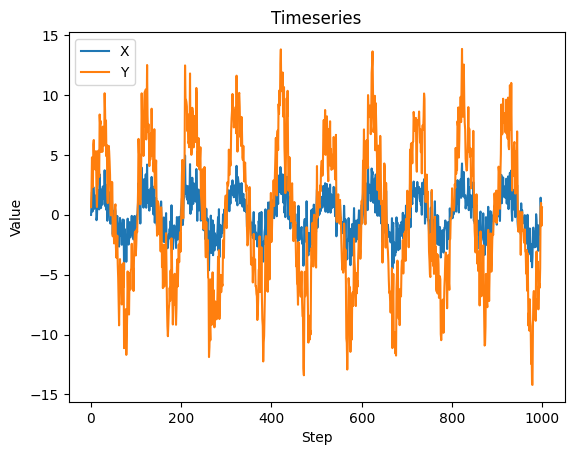

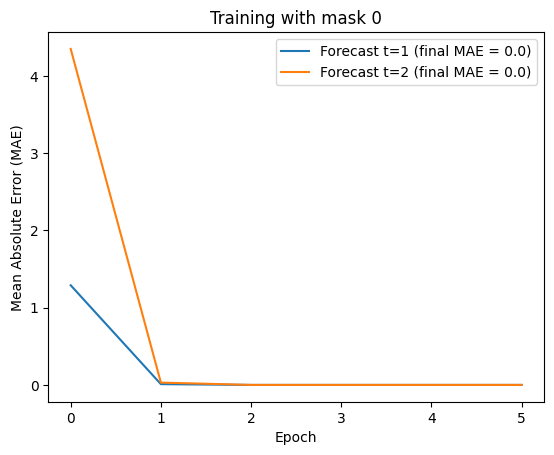

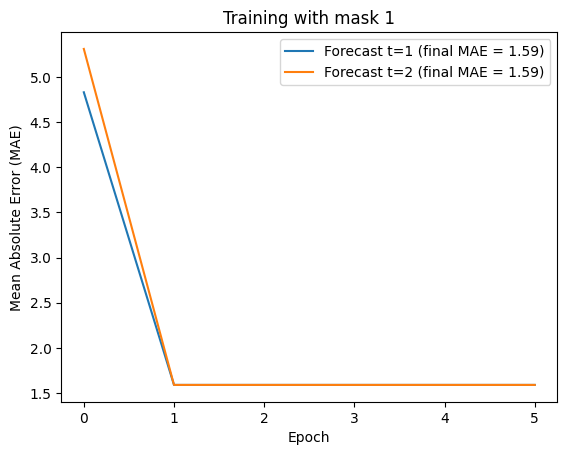

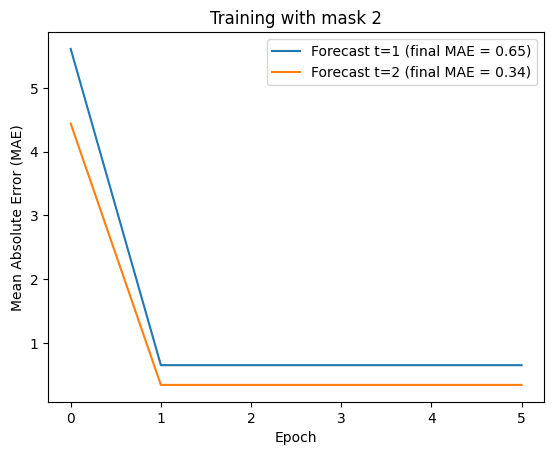

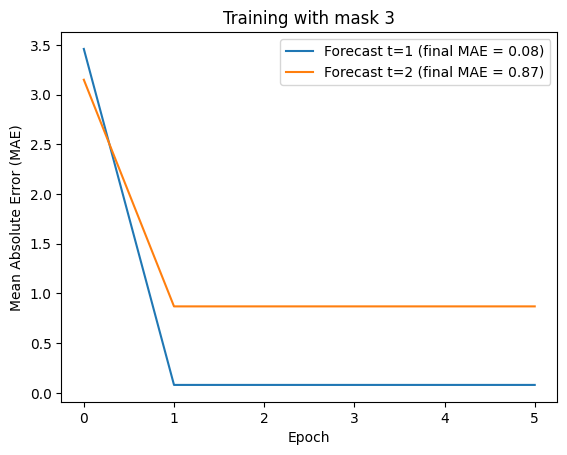

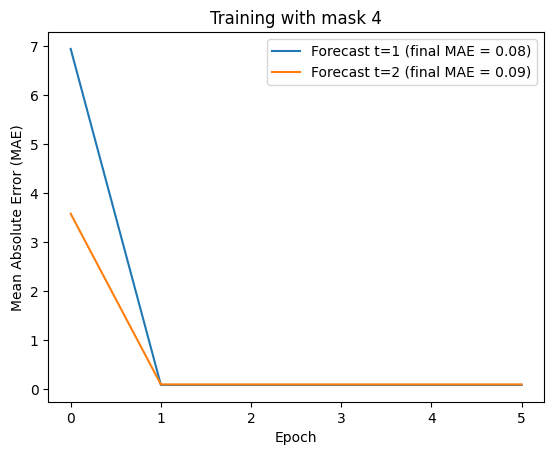

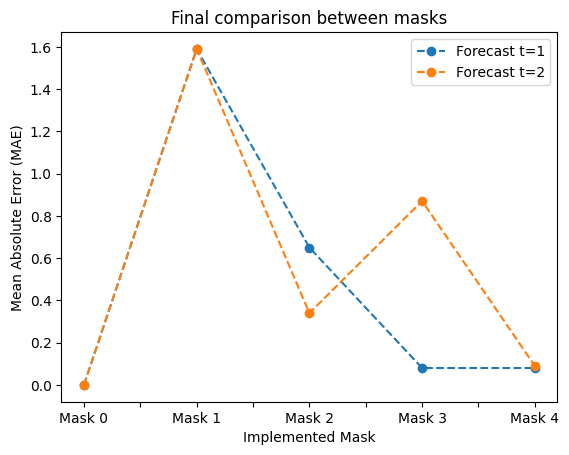

In [6]:
NUM_SAMPLES = 1000
WEIGHT_X = 2.0
WEIGHT_Y_AUTOREGRESSIVE = 0.5
WEIGHT_NOISE_Y = 0.1
RESULTS_DIR = "results"

X = "X"
Y = "Y"

PAST_HORIZON = 1
FORECAST_HORIZON = 2
WINDOW_STEP = 1

np.random.seed(42)

past_steps = list(range(-PAST_HORIZON + 1, 1))
future_steps = list(range(1, FORECAST_HORIZON + 1))
combined_steps = past_steps + future_steps


def plot_true_network() -> None:
    g = graphviz.Digraph()
    if WEIGHT_NOISE_Y > 0:
        g.node(name="Noise")
    g.node(name="X", label="<X<sub>t</sub>>")
    g.node(name="Y", label="<Y<sub>t</sub>>")
    if WEIGHT_NOISE_Y > 0:
        g.edge(tail_name="Noise", head_name="Y", label=f"{WEIGHT_NOISE_Y}")
    g.edge(tail_name="X", head_name="Y", label=f"{WEIGHT_X}")
    g.edge(tail_name="Y", head_name="Y", label=f"{WEIGHT_Y_AUTOREGRESSIVE}")
    g.render(f"{RESULTS_DIR}/true_network_recursive.gv", format="png", view=False)

    g = graphviz.Digraph()
    if WEIGHT_NOISE_Y > 0:
        g.node(name="Noise")
    g.node(name="X", label="<X<sub>t</sub>>")
    g.node(name="X-1", label="<X<sub>t-1</sub>>")
    g.node(name="Y", label="<Y<sub>t</sub>>")
    g.node(name="Y-1", label="<Y<sub>t-1</sub>>")
    if WEIGHT_NOISE_Y > 0:
        g.edge(tail_name="Noise", head_name="Y", label=f"{WEIGHT_NOISE_Y}")
        g.edge(tail_name="Noise", head_name="Y-1", label=f"{WEIGHT_NOISE_Y}")
    g.edge(tail_name="X-1", head_name="Y-1", label=f"{WEIGHT_X}")
    g.edge(tail_name="X", head_name="Y", label=f"{WEIGHT_X}")
    g.edge(tail_name="Y-1", head_name="Y", label=f"{WEIGHT_Y_AUTOREGRESSIVE}")
    g.render(f"{RESULTS_DIR}/true_network_unrolled.gv", format="png", view=False)


def plot_trained_weights(
        mask: pd.DataFrame,
        mask_index: int,
        trained_weights: pd.DataFrame,
) -> None:
    g = graphviz.Digraph()

    for tail in mask.columns:
        "<X<sub>t</sub>>"
        label = f"<{tail[1]}<sub>{tail[0]}</sub>>"
        name = f"{tail[1]}_{tail[0]}_tail"
        g.node(name=name, label=label)

    for head in mask.index:
        label = f"<{head[1]}<sub>{head[0]}</sub>>"
        name = f"{head[1]}_{head[0]}_head"
        g.node(name=name, label=label)

    for tail in mask.columns:
        for head in mask.index:
            if mask.loc[head, tail] == 1.0:
                g.edge(
                    tail_name=f"{tail[1]}_{tail[0]}_tail",
                    head_name=f"{head[1]}_{head[0]}_head",
                    label=f"{trained_weights.loc[head, tail]}",
                )

    g.render(f"{RESULTS_DIR}/mask_{mask_index}.gv", format="png", view=False)


def create_dataset() -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Create initial timeseries
    df = pd.DataFrame(
        columns=[X, Y],
        index=range(NUM_SAMPLES),
        dtype=float,
    )

    df[X] = 2 * np.sin(
        np.linspace(0, 2 * np.pi * NUM_SAMPLES / 100, NUM_SAMPLES)
    ) + 1.0 * np.random.randn(NUM_SAMPLES)
    df[Y] = WEIGHT_X * df[X] + WEIGHT_NOISE_Y * np.random.randn(NUM_SAMPLES)

    for row in range(1, len(df)):
        df.loc[row, Y] += WEIGHT_Y_AUTOREGRESSIVE * df.loc[row - 1, Y]
    df = df.iloc[1:, :]

    print(df.mean(axis=0).round(decimals=2).to_string())

    df.plot()
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.title(f"Timeseries")
    # plt.savefig(f"{RESULTS_DIR}/dataset_timeseries.png")

    plot_true_network()

    # Create training data samples:
    window_size = PAST_HORIZON + FORECAST_HORIZON

    samples = [
        df.iloc[i: i + window_size, :]
        .set_index(pd.Index(combined_steps))
        .copy(deep=True)
        for i in range(0, len(df) - window_size + 1, WINDOW_STEP)
    ]

    print(samples[0].round(decimals=2).to_string())

    features = pd.DataFrame([s.stack() for s in samples])

    targets = pd.DataFrame([s.stack().loc[future_steps, [Y]] for s in samples])

    return features, targets


def create_masks(
        features: pd.DataFrame,
        targets: pd.DataFrame,
) -> Tuple[pd.DataFrame, ...]:
    base_mask = pd.DataFrame(
        index=targets.columns,
        columns=features.columns,
        data=0.0,
    )

    # Use Case 0: No mask:
    mask0 = base_mask.copy(deep=True)
    mask0.loc[:, :] = 1.0

    # Use Case 1: Separate linear regression:
    mask1 = base_mask.copy(deep=True)
    for time_step in future_steps:
        # Allow each target Y in the future to access its feature X from the same time step:
        mask1.loc[(time_step, Y), (time_step, X)] = 1.0

    # Use Case 2: Share X across time
    mask2 = base_mask.copy(deep=True)
    # Allow each target in the future to access all features from any time step:
    mask2.loc[(future_steps, Y), (combined_steps, X)] = 1.0

    # Use Case 3: Separate linear regression with autoregressive input from the past
    mask3 = base_mask.copy(deep=True)
    for time_step in future_steps:
        # Allow each target in the future to access its features from the same time step:
        mask3.loc[(time_step, Y), (time_step, X)] = 1.0
    # Additionally allow access to targets from the past
    mask3.loc[(future_steps, Y), (past_steps, Y)] = 1.0

    # Use Case 4: Share X across time and allow autoregressive input from the past
    mask4 = base_mask.copy(deep=True)
    # Allow access to all features (like use case 2)
    mask4.loc[(future_steps, Y), (combined_steps, X)] = 1.0
    # Additionally allow access to targets from the past
    mask4.loc[(future_steps, Y), (past_steps, Y)] = 1.0

    return mask0, mask1, mask2, mask3, mask4


def run_training(
        features: pd.DataFrame,
        targets: pd.DataFrame,
        mask: pd.DataFrame,
        mask_index: int,
) -> pd.Series:
    training_results = train_model(
        features=features.values,
        targets=targets.values,
        mask=mask.values,
    )

    loss_timeseries = pd.DataFrame(training_results.loss_timeseries).round(decimals=2)

    final_metrics = loss_timeseries.copy(deep=True)
    final_metrics.columns = [f"Forecast t={col + 1}" for col in final_metrics.columns]
    final_metrics = final_metrics.iloc[-1].rename(f"Mask {mask_index}")

    loss_timeseries.columns = [
        f"Forecast t={col + 1} (final MAE = {loss_timeseries.loc[len(loss_timeseries) - 1, col]})"
        for col in loss_timeseries.columns
    ]

    loss_timeseries.plot()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.title(f"Training with mask {mask_index}")
    plt.savefig(f"{RESULTS_DIR}/training_mask_{mask_index}.png")

    trained_weights = pd.DataFrame(
        training_results.trained_weights,
        index=mask.index,
        columns=mask.columns,
    )

    trained_weights = (trained_weights * mask).round(decimals=2)

    print(trained_weights.to_string())

    plot_trained_weights(
        mask=mask,
        mask_index=mask_index,
        trained_weights=trained_weights,
    )

    return final_metrics


def main() -> None:
    features, targets = create_dataset()

    mask0, mask1, mask2, mask3, mask4 = create_masks(
        features=features,
        targets=targets,
    )

    final_metrics_list = []

    for mask_index, mask in enumerate([mask0, mask1, mask2, mask3, mask4], start=0):
        final_metrics = run_training(
            features=features,
            targets=targets,
            mask=mask,
            mask_index=mask_index,
        )
        final_metrics_list.append(final_metrics)

    final_metrics_timeseries = pd.concat(final_metrics_list, axis=1)
    final_metrics_timeseries.T.plot(style="o--")
    plt.xlabel("Implemented Mask")
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.title(f"Final comparison between masks")
    plt.savefig(f"{RESULTS_DIR}/loss_comparison.png")


if __name__ == "__main__":
    main()